In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.svm import  LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from string import punctuation
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV



In [38]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


In [39]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv', 
                 delimiter=',', encoding='ISO-8859-1')
df.columns = ['sentiment','id','date','query','user','text']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1048572 non-null  int64 
 1   id         1048572 non-null  int64 
 2   date       1048572 non-null  object
 3   query      1048572 non-null  object
 4   user       1048572 non-null  object
 5   text       1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


#As we can see the info of the df returned that it doesnt have any null value

In [40]:

df.head(10)

,sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467812579,Mon Apr 06 22:20:17 PDT 2009,NO_QUERY,pardonlauren,I just re-pierced my ears
8,0,1467812723,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,TLeC,@caregiving I couldn't bear to watch it. And ...
9,0,1467812771,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,robrobbierobert,"@octolinz16 It it counts, idk why I did either..."


In [41]:
df['sentiment'] = df['sentiment'].replace({4:1})

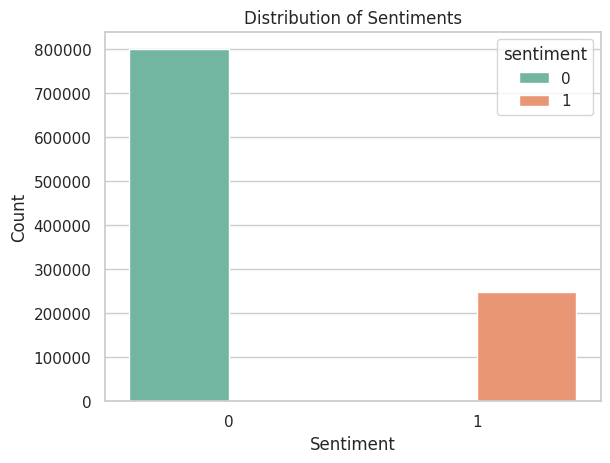

In [42]:
sns.set(style="whitegrid") 

sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')

# Customize plot labels and title if needed
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

the dataset is extremely unbalanced so we downsample to have a balanced data set

In [43]:
## majority class 0
df_majority = df[df['sentiment']==0]
## minority class 1
df_minority = df[df['sentiment']==1]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,   
                                 n_samples=len(df_minority),    
                                 random_state=42) 
df = pd.concat([df_majority_downsampled, df_minority], ignore_index=True)
df.head()

,sentiment,id,date,query,user,text
0,0,1974671959,Sat May 30 13:36:36 PDT 2009,NO_QUERY,jessicatamman,@amruth92 early bird! and you didnt reply to m...
1,0,2247756082,Fri Jun 19 19:34:35 PDT 2009,NO_QUERY,TinaF75,It is sooo hot tonight. I wish I had my pool u...
2,0,2286390032,Mon Jun 22 16:22:54 PDT 2009,NO_QUERY,hellomariely,@darkandrez No washing clothes
3,0,2061140384,Sat Jun 06 20:15:32 PDT 2009,NO_QUERY,Pochaccoyoly,@asexiness That sucks!
4,0,1880667573,Fri May 22 02:03:48 PDT 2009,NO_QUERY,Milseyworks,"until now, i haven't watch yet the finale of A..."


In [44]:
df = df.drop_duplicates('text')
df=df.drop(columns=['query'])   
df.head()

,sentiment,id,date,user,text
0,0,1974671959,Sat May 30 13:36:36 PDT 2009,jessicatamman,@amruth92 early bird! and you didnt reply to m...
1,0,2247756082,Fri Jun 19 19:34:35 PDT 2009,TinaF75,It is sooo hot tonight. I wish I had my pool u...
2,0,2286390032,Mon Jun 22 16:22:54 PDT 2009,hellomariely,@darkandrez No washing clothes
3,0,2061140384,Sat Jun 06 20:15:32 PDT 2009,Pochaccoyoly,@asexiness That sucks!
4,0,1880667573,Fri May 22 02:03:48 PDT 2009,Milseyworks,"until now, i haven't watch yet the finale of A..."


TEXT CLEANING AND PREPROCESSING


In [45]:

def textprocessing(text):
    text = str(text)
    text = text.lower()                                                          # converting all uppercase letters to lowercase
    text = re.sub(r"https\S+|www\S+|https\S+"," ",text,flags=re.MULTILINE)       # removing all links from dataset
    text=re.sub("(\\d|\\W)+"," ",text)       
    text = re.sub(r'\@\w+|\#'," ",text)                                          # removing # and @ symbols from dataset
    text = re.sub(r'[^\w\s\`]'," ",text)                                         # removing other symbols like ^ except '
    text_tokens = word_tokenize(text) 
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text_tokens if not word in   list(punctuation)] 
    text1 = " ".join(text)
    
    return text1 
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()

    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text 
            if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

In [46]:
data_cleaned = pd.DataFrame()
df['text'] = df['text'].apply(textprocessing)
df['text'].head()

0    amruth earli bird and you didnt repli to my fa...
1    it is sooo hot tonight i wish i had my pool up...
2                             darkandrez no wash cloth
3                                      asexi that suck
4    until now i haven t watch yet the final of ai ...
Name: text, dtype: object

In [49]:
positive = df[df['sentiment'] == 1]
positive_list = positive['text'].tolist()

# Storing negative data seperately

negative = df[df['sentiment'] == 0]
negative_list = negative['text'].tolist()

In [50]:
negative_text = ' '.join(df[df['sentiment'] == 0]['text'])
positive_text = ' '.join(df[df['sentiment'] == 1]['text'])
df = df[['sentiment','text']]
df.head()

,sentiment,text
0,0,amruth earli bird and you didnt repli to my fa...
1,0,it is sooo hot tonight i wish i had my pool up...
2,0,darkandrez no wash cloth
3,0,asexi that suck
4,0,until now i haven t watch yet the final of ai ...


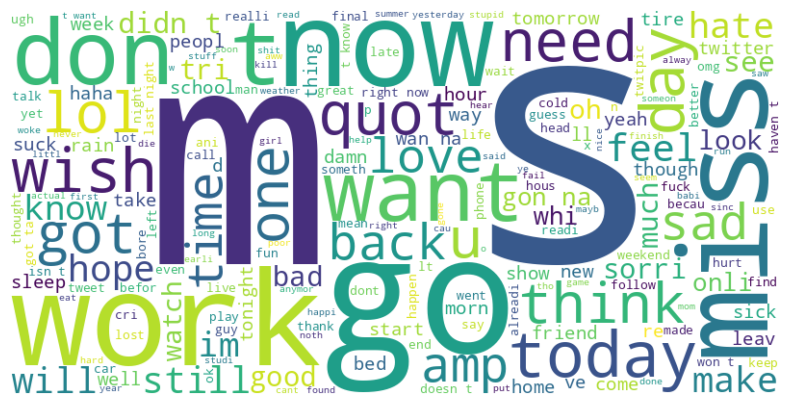

In [51]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

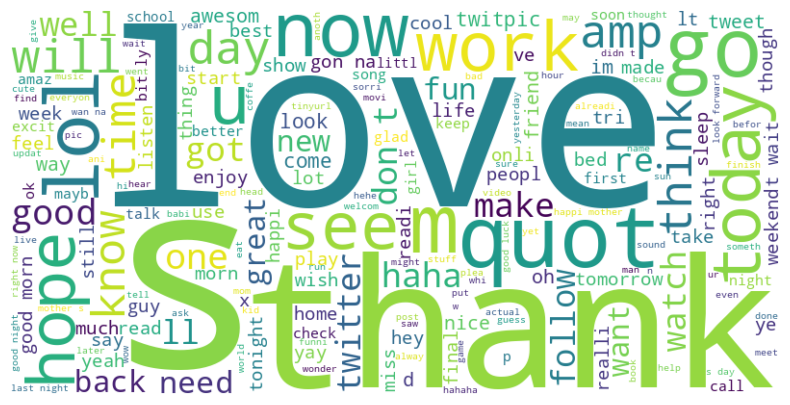

In [52]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [56]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_list)
negative_tokens_for_model = get_tweets_for_model(negative_list)

In [57]:
import random 
positive_dataset = [(review_dict, "Positive")
                     for review_dict in positive_tokens_for_model]

negative_dataset = [(review_dict, "Negative")
                     for review_dict in negative_tokens_for_model]
dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:333091]
test_data = dataset[333091:]

In [58]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print(" Training Accuracy is:", round(classify.accuracy(classifier, train_data),2)*100)

print("Testing Accuracy is:", round(classify.accuracy(classifier, test_data),2)*100)

print(classifier.show_most_informative_features(10))

 Training Accuracy is: 51.0
Testing Accuracy is: 51.0
Most Informative Features
                       â = True           Negati : Positi =    253.1 : 1.0
                       ð = True           Negati : Positi =     10.3 : 1.0
                       ø = True           Negati : Positi =      6.3 : 1.0
                       ï = True           Positi : Negati =      4.9 : 1.0
                       ½ = True           Positi : Negati =      4.5 : 1.0
                       ç = True           Negati : Positi =      3.0 : 1.0
                       í = True           Negati : Positi =      2.3 : 1.0
                       q = True           Positi : Negati =      1.4 : 1.0
                       _ = True           Positi : Negati =      1.4 : 1.0
                       s = None           Positi : Negati =      1.3 : 1.0
None


In [60]:
x = df['text']
y = df['sentiment']

vectorizer = tf()
vectors = vectorizer.fit_transform(x)


SVM without PCA

In [61]:
X_train_svm, X_temp_svm, y_train_svm, y_temp_svm = train_test_split(vectors, y, test_size=0.3, random_state=42)

X_validation_svm, X_test_svm, y_validation_svm, y_test_svm = train_test_split(X_temp_svm, y_temp_svm, test_size=0.5, random_state=52)

In [63]:
classifier = CalibratedClassifierCV(LinearSVC(dual = True), method='sigmoid')
classifier.fit(X_train_svm, y_train_svm)

CalibratedClassifierCV(estimator=LinearSVC())

In [65]:
svm_predictions_train = classifier.predict(X_train_svm)

accuracy = accuracy_score(y_train_svm, svm_predictions_train)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_train_svm, svm_predictions_train))

Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89    172416
           1       0.90      0.89      0.89    172784

    accuracy                           0.89    345200
   macro avg       0.89      0.89      0.89    345200
weighted avg       0.89      0.89      0.89    345200



In [66]:
svm_prediction_test = classifier.predict(X_test_svm)


accuracy = accuracy_score(y_test_svm, svm_prediction_test)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_test_svm, svm_prediction_test))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     37178
           1       0.78      0.80      0.79     36794

    accuracy                           0.79     73972
   macro avg       0.79      0.79      0.79     73972
weighted avg       0.79      0.79      0.79     73972



In [67]:
svm_predictions_validation= classifier.predict(X_validation_svm)

accuracy = accuracy_score(y_validation_svm, svm_predictions_validation)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_validation_svm, svm_predictions_validation))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     37093
           1       0.78      0.80      0.79     36878

    accuracy                           0.79     73971
   macro avg       0.79      0.79      0.79     73971
weighted avg       0.79      0.79      0.79     73971



SVM with PCA

In [68]:
X_train_svm, X_temp_svm, y_train_svm, y_temp_svm = train_test_split(vectors, y, test_size=0.3, random_state=42)

X_validation_svm, X_test_svm, y_validation_svm, y_test_svm = train_test_split(X_temp_svm, y_temp_svm, test_size=0.5, random_state=52)

In [69]:
n_components = 100  
svd = TruncatedSVD(n_components=n_components)
X_train_svm_pca = svd.fit_transform(X_train_svm)
X_validation_svm_pca = svd.transform(X_validation_svm)
X_test_svm_pca = svd.transform(X_test_svm)

In [70]:
svm_model = LinearSVC(dual = True)
svm_model.fit(X_train_svm_pca, y_train_svm)


y_pred_validation_svm = svm_model.predict(X_validation_svm_pca)
accuracy_validation_svm = accuracy_score(y_validation_svm, y_pred_validation_svm)
print(f"Accuracy on the validation set: {accuracy_validation_svm}")


y_pred_test_svm = svm_model.predict(X_test_svm_pca)
accuracy_test_svm = accuracy_score(y_test_svm, y_pred_test_svm)
print(f"Accuracy on the test set: {accuracy_test_svm}")

Accuracy on the validation set: 0.7104405780643765
Accuracy on the test set: 0.710106526793922


In [76]:
def metrics(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=None)
    disp_train.plot(ax=axes[0], cmap='greens', values_format='d')
    axes[0].set_title('Training Confusion Matrix ')

    
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=None)
    disp_test.plot(ax=axes[1], cmap='greens', values_format='d')
    axes[1].set_title('Testing Confusion Matrix')

    plt.show()

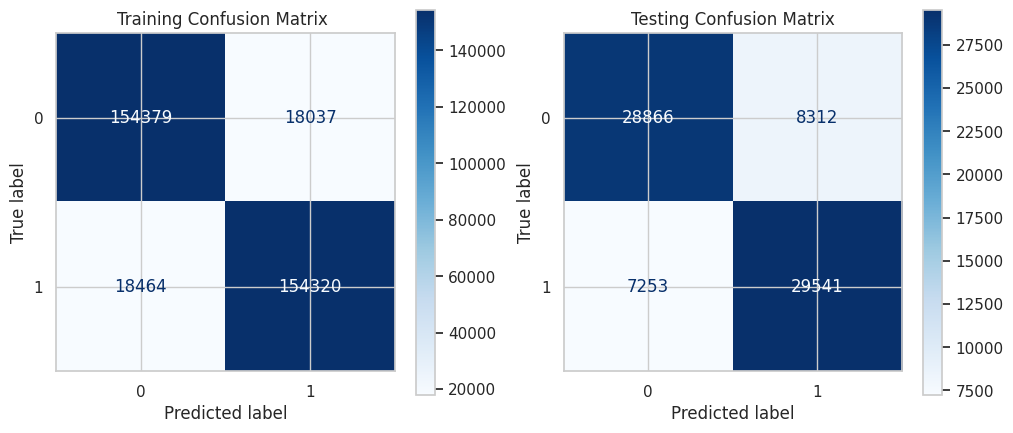

In [72]:
metrics(y_train_svm,svm_predictions_train ,y_test_svm,svm_prediction_test)

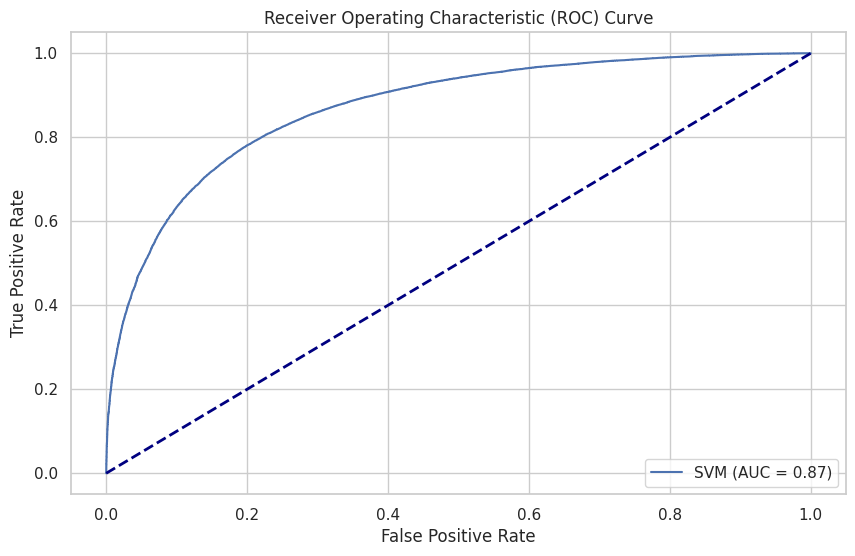

In [73]:
def plot_roc_curve(fpr, tpr, label, title):
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label, auc(fpr, tpr)))


plt.figure(figsize=(10, 6))
svm_probs = classifier.predict_proba(X_test_svm)[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test_svm, svm_probs)
plot_roc_curve(svm_fpr, svm_tpr, 'SVM', 'ROC Curve - SVM')

# Plotting diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()


**As we can see we used NaiveBayes Classifier and also svc with and without pca the best we could obtained was 89% on train data and 79% on both. validation and test data**